In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import dataset_helper

for graph_dataset_cache_file in dataset_helper.get_all_cached_graph_datasets():
    if 'ling-spam' not in graph_dataset_cache_file: continue
    X, Y = dataset_helper.get_dataset_cached(graph_dataset_cache_file)
    break

In [27]:
import graph_helper
all_node_labels = graph_helper.get_all_node_labels(X, as_sorted_list = False)
with open('tmp/ling-spam-labels.txt', 'w') as f:
    f.write('\n'.join(all_node_labels))

In [28]:
import gensim
import preprocessing
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if 'ling-spam' not in dataset_name: continue
    X, Y = dataset_helper.get_dataset(dataset_name=dataset_name)
    X = preprocessing.preprocess_text_spacy(X, concat = False, only_nouns = False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-257ccd86f4cd>", line 5, in <module>
    X, Y = dataset_helper.get_dataset(dataset_name=dataset_name)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/davidgengenbach/anaconda3/lib/python3.5/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_c

KeyboardInterrupt: 

In [ ]:
X_as_words = [[y.text for y in x] for x in X]
model = gensim.models.Word2Vec(X_as_words, size=50, window=5, min_count=1, workers=4)
vocab = model.wv
del model

## Doc2Vec

In [ ]:
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from transformers.wl_graph_kernel_transformer import WLGraphKernelTransformer
from transformers.preprocessing_transformer import PreProcessingTransformer
from transformers.d2v_transformer import Doc2VecTransformer
import graph_helper
import dataset_helper
import wl
import os

for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name != 'r8': continue
        
    X, Y = dataset_helper.get_dataset(dataset_name, use_cached= True)
    
    p = Pipeline([
        ('preprocessing', PreProcessingTransformer(only_nouns = True)),
        ('d2v', Doc2VecTransformer()),
        ('clf', sklearn.linear_model.PassiveAggressiveClassifier())
    ])
    
    param_grid = dict(
        d2v__embedding_size = [500],
        d2v__iterations = [10],
        d2v__infer_steps = [10],
        clf__n_iter = [100],
        clf__class_weight = ['balanced']
    )

    cv = sklearn.model_selection.StratifiedKFold(n_splits = 3, random_state= 42, shuffle= True)
    gscv = GridSearchCV(estimator = p, param_grid=param_grid, cv=cv, scoring = 'f1_macro', n_jobs=1, verbose = 11)
    gscv_result = gscv.fit(X, Y)
    print(gscv_result.best_estimator_, gscv_result.cv_results_)

## DeepWalk

In [ ]:
import deepwalk
from deepwalk import graph
from deepwalk import walks as serialized_walks
from gensim.models import Word2Vec
from deepwalk.skipgram import Skipgram
import dataset_helper
import graph_helper
import random
from gensim.models import Word2Vec
import tsne
import matplotlib.pyplot as plt

max_memory_data_size = 1000000000
number_walks = 1000
representation_size = 64
seed = 0
undirected = True
vertex_freq_degree = False
walk_length = 60
window_size = 10
workers = 1
output = 'data/DUMP'

for dataset in dataset_helper.get_all_available_dataset_names():
    cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_cooccurrence_{}.npy'.format(dataset)
    X, Y = dataset_helper.get_dataset(dataset, preprocessed = False, use_cached=True, transform_fn=graph_helper.convert_dataset_to_co_occurence_graph_dataset, cache_file=cache_file)
    break
    
models = []
for idx, g in enumerate(X):
    if idx == 3: break
    print('Graph: {:>4}'.format(idx))
    G = graph.from_networkx(g)

    print("Number of nodes: {}".format(len(G.nodes())))
    if len(G.nodes()) == 0:
        continue

    num_walks = len(G.nodes()) * number_walks

    print("Number of walks: {}".format(num_walks))

    data_size = num_walks * walk_length

    print("Data size (walks*length): {}".format(data_size))

    print("Walking...")
    walks = graph.build_deepwalk_corpus(G, num_paths=number_walks, path_length=walk_length, alpha=0, rand=random.Random(seed))
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, workers=workers)

    #model.wv.save_word2vec_format(output)
    models.append(model)
print('Finished')

## tSNE

In [ ]:
for model in models:
    print('Next')
    vectors = tsne.get_tsne_embedding(model)
    tsne.plot_embedding(model, vectors)
    plt.show()

## Test WL phi computation

In [ ]:
from joblib import Parallel, delayed

from time import time
phi_list_train_last = phi_list_train[-1]
test_graphs = train[:100]

def test_graph(idx, a):
    topic, graph = a
    #if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(phi_list_train, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
    print('Finished: {}'.format(idx))
    
mats = Parallel(n_jobs=2)(delayed(test_graph)(*d) for d in list(enumerate(test_graphs)))

for idx, (topic, graph) in enumerate(test_graphs):
    break
    if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(real_, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
            break


In [ ]:
import functools
import wl
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, vstack

def get_all_nodes(gs):
    return functools.reduce(lambda acc, x: acc | set(x), gs, set())

def get_wl_args(graphs):
    adjs = [nx.adjacency_matrix(g).toarray() for g in graphs]
    nodes = [g.nodes() for g in graphs]
    return adjs, nodes


g1 = nx.DiGraph()
g1.add_edge('A', 'B')
g1.add_edge('B', 'C')

g2 = nx.DiGraph()
g2.add_edge('A', 'B')
g2.add_edge('B', 'C')
g2.add_edge('B', 'D')

g3 = nx.DiGraph()
g3.add_edge('E', 'F')
g3.add_node('G')
all_graphs = (g1, g2, g3)

DEBUG = False
H = 10

all_nodes = get_all_nodes((g1, g2, g3))

adjs, nodes = get_wl_args((g1, g2))
K_1_2, phi_1_2, label_lookups_1_2, label_counters_1_2 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)
adjs, nodes = get_wl_args((g1, g2, g3))
K_1_2_3, phi_1_2_3, label_lookups_1_2_3, label_counters_1_2_3 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)

TARGET_GRAPH = g3
K_1_2_3_test, phi_1_2_3_test = wl.WL_compute_new(
    ad_list=[nx.adjacency_matrix(TARGET_GRAPH).toarray()],
    node_label=[TARGET_GRAPH.nodes()],
    label_counters_prev = label_counters_1_2,
    all_nodes= all_nodes,
    h = H,
    k_prev = np.copy(K_1_2),
    phi_prev = np.copy(phi_1_2),
    label_lookups_prev = np.copy(label_lookups_1_2)
)

phi_3_test = wl.compute_phi(g3, phi_1_2_3[0].shape, label_lookups_1_2_3, label_counters_1_2_3, h = H)
for idx, (real, new) in enumerate(zip(phi_1_2_3, phi_3_test)):
    real = real[:,2]
    new = lil_matrix(new.reshape(-1,1))
    if not np.array_equiv(real.todense(), new.todense()):
        print('Phi not equal', idx)

if 0 == 1:
    for i, (a, b) in enumerate(zip(phi_1_2_3_test, phi_1_2_3)):
        if not np.array_equiv(a - b.todense(), np.zeros(b.shape, dtype = np.int32)):
            print("\tPhi different! {}".format(i))
            print(np.argwhere((a - b) != 0))

    for i, (a, b) in enumerate(zip(K_1_2_3_test, K_1_2_3)):
        if not np.array_equal(a, b):
            print(np.argwhere((a - b) != 0))
            print("\tK different! {}".format(i))


In [ ]:
import networkx as nx
import fast_wl
import dataset_helper
from time import time
import wl
import graph_helper
import gc

gc.collect()

H = 4

def wl_old(X, h = H):
    node_label = [sorted(g.nodes()) for g in X]
    ad_list = [nx.adjacency_matrix(g, nodelist=label) for g, label in zip(X, node_label)]
    all_nodes = graph_helper.get_all_node_labels(X)
    K, phi_list, label_lookups, label_counters = wl.WL_compute(ad_list, node_label, h, all_nodes = all_nodes, compute_k = False, keep_phi_history = True, DEBUG = False)
    return phi_list
    
def wl_fast(X, h = H):
    phi_lists, new_label_lookups, new_label_counters = fast_wl.fast_wl_compute(X, h = H)
    return phi_lists

for dataset_cache_file in dataset_helper.get_all_cached_graph_datasets():
    print(dataset_cache_file)
    if False or 'gml' not in dataset_cache_file or 'ng20' not in dataset_cache_file: continue
    X, Y = dataset_helper.get_dataset_cached(dataset_cache_file)
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nx.number_of_nodes(x) > 0 and nx.number_of_edges(x) > 0])
    for x in [wl_fast]:
        print('Starting: {}'.format(x))
        t = time()
        phi_lists = x(X)
        print('Time needed for {} elements and {} iterations: {:.2f}s'.format(len(X), H, time() - t))

if False:
    g1 = nx.Graph()
    g1.add_edge('A', 'B')
    g1.add_edge('A', 'C')

    g2 = g1.copy()

    g3 = nx.Graph()
    g3.add_edge('A', 'D')

    graphs = [g1, g2, g3]
    phi_lists, new_label_lookups, new_label_counters = fast_wl.fast_wl_compute(graphs, h = 1)
    print(phi_lists[-1].todense())

In [ ]:
dataset_name = 'ling-spam'

In [ ]:
import embeddings
embeddings_ = embeddings.get_embedding_model('data/embeddings/graph-embeddings/{}.w2v.txt'.format(dataset_name), with_gensim = True)

In [ ]:
import numpy as np
from time import time
import coreference

labels = list(embeddings_.vocab.keys())
np.random.shuffle(labels)

topn = 3
most_similar_labels = coreference.get_most_similar_labels(labels, embeddings_, topn=topn)

In [ ]:
results = {}
tresholds = [0.99999, 0.9999, 0.999, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
#tresholds = [0.9999]

for n in range(0, topn):
    most_similar_labels_ = {label: m[:n + 1] for label, m in most_similar_labels.items()}
    for treshold in tresholds:
        print('n={}, threshold={}'.format(n, treshold))
        results[(n + 1, treshold)] = coreference.create_label_cliques_by_similarity(most_similar_labels_, threshold = treshold)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

num_labels = len(labels)

for (n, treshold), lookup in results.items():
    cliques = coreference.get_cliques_from_lookup(lookup)
    similarity_counter = {'similar': len(lookup.keys()), 'unsimilar': num_labels - len(lookup.keys())}
    clique_lenghts = [len(x) for x in list(cliques.values())]
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    fig.suptitle('Treshold: {}, N={}'.format(treshold, n), fontsize = 16)

    pd.DataFrame(clique_lenghts).plot(ax = axes[0], kind = 'hist', logy = True, legend = False, title = "Histogram of clique lengths".format(treshold))
    pd.DataFrame(list(similarity_counter.items()), columns = ['name', 'count']).set_index('name').plot(ax = axes[1], kind = 'bar', legend = False, title = '# of labels that have been merged vs. not merged')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig('tmp/{:.5f}.{}.png'.format(treshold, n), dpi = 120)
    plt.close(fig)

In [ ]:
#sns.set_context("notebook", font_scale=1.5)
sns.set('notebook', 'white')
#for treshold, vals in df.groupby('threshold'):
    #display(vals)
def plot_by(df, by, bins = 15, title = '', figsize = (12, 5), fontsize = 16):
    fig, ax = plt.subplots(figsize = figsize)

    data = []
    labels = []
    for n, vals in df.groupby(by):
        labels.append(n)
        data.append(vals.clique_length)
    ax.hist(data, bins = bins, alpha=0.7, label=labels, log = True)
    fig.suptitle(title, fontsize = fontsize)
    ax.legend(loc='upper right', fontsize = fontsize)
    ax.set_xlabel('clique sizes')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax
fig, ax = plot_by(df, 'n', title = 'Clique size histogram by n (all thresholds together)')
fig.savefig('tmp/clique_size_by_n_all_thresholds.png', dpi = 120)
fig, ax = plot_by(df, 'threshold', title = 'Clique size histogram by threshold (all n together)')
fig.savefig('tmp/clique_size_by_threshold_all_n.png', dpi = 120)
fig, ax = plot_by(df[df.threshold == 0.6], 'n', title = 'Clique size histogram by n (threshold=0.6)')
fig.savefig('tmp/clique_size_by_n_threshold_0.6.png', dpi = 120)
plt.show()

In [ ]:
import dataset_helper
import graph_helper
for graph_cache_file in dataset_helper.get_all_cached_graph_datasets():
    print('Dataset: {}'.format(graph_cache_file.split('/')[-1]))
    X, Y = dataset_helper.get_dataset_cached(graph_cache_file)
    all_nodes = graph_helper.get_all_node_labels(X, as_sorted_list = False)
    print('\t{:>10}'.format(len(all_nodes)))

In [ ]:
import dataset_helper
import graph_helper
limit_dataset = 'ling-spam'
for cache_file in dataset_helper.get_all_cached_graph_datasets():
    if limit_dataset and limit_dataset not in cache_file: continue
    if 'all' not in cache_file: continue
    X, Y = dataset_helper.get_dataset_cached(cache_file)
    break


In [ ]:
import coreference
import embeddings

pre_trained_embedding = embeddings.get_embedding_model(
        'data/embeddings/glove/glove.6B.50d.w2v.txt', binary=False, first_line_header=True, with_gensim=True)

In [ ]:
import dataset_helper
trained_embedding = dataset_helper.get_w2v_embedding_for_dataset('ling-spam')
labels = ['this', 'love', 'love similarity']
embeddings_pre_trained, not_found_pre_trained_coreferenced, not_found_trained, not_found_pre_trained, lookup = embeddings.get_embeddings_for_labels_with_lookup(labels, trained_embedding, pre_trained_embedding)
embeddings_pre_trained


In [ ]:
import dataset_helper
for cache_file in dataset_helper.get_all_cached_graph_phi_datasets():
    dataset = dataset_helper.get_dataset_name_from_graph_cachefile(cache_file)
    print(cache_file, dataset)

In [ ]:
import pickle
import embeddings

dataset = 'ling-spam'

embedding = embeddings.load_word2vec_format(fname = 'data/embeddings/graph-embeddings/{}.w2v.txt'.format(dataset), binary = False)

In [ ]:
with open('data/embeddings/graph-embeddings/{}.similar-els.npy'.format(dataset), 'rb') as f:
    similar_els = pickle.load(f)
    
k = list(similar_els.keys())
k_ = k[-1]
k_, similar_els[k_]

In [ ]:
import pickle
with open('data/results/text_ling-spam.results.npy', 'rb') as f:
    results = pickle.load(f)

In [ ]:
import create_coreference_embeddings
import embeddings

pre_trained_embedding = embeddings.get_embedding_model('data/embeddings/glove/glove.6B.50d.w2v.txt', binary=False, first_line_header=True, with_gensim=True)

In [ ]:
import pickle

with open('data/embeddings/graph-embeddings/ling-spam.similar-els.npy', 'rb') as f:
    similar_els = pickle.load(f)

In [ ]:
import coreference

lookup = coreference.create_label_cliques_by_similarity(similar_els, topn = 1, threshold=0.7)
not_merged = coreference.get_non_coreferenced_labels(['yes'],lookup)
cliques = coreference.get_cliques_from_lookup(lookup)

len(cliques.keys()), len(lookup.keys()), not_merged

In [ ]:
with open('data/embeddings/graph-embeddings/ling-spam.label-lookup.npy', 'rb') as f:
    lookup = pickle.load(f)
    
len(lookup.keys())

In [ ]:
import dataset_helper
import pickle
import numpy as np
import sklearn
graph_cache_file = 'dataset_graph_gml_ng20-single.npy'
X, Y = dataset_helper.get_dataset_cached('data/CACHE/{}'.format(graph_cache_file))
X, Y = np.array(X, dtype=object), np.array(Y, dtype=object)
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 20, random_state=42)
for train_index, test_index in sss.split(X, Y):
    X_test, Y_test = X[test_index], Y[test_index]
    break
with open('data/CACHE/dataset_graph_gml_small-single.npy', 'wb') as f:
    pickle.dump((X_test.tolist(), Y_test.tolist()), f)
    
    

ling-spam


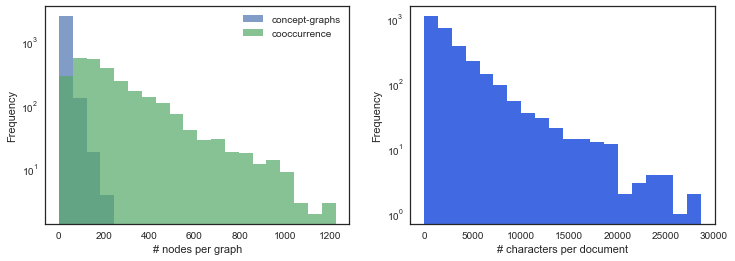

ng20


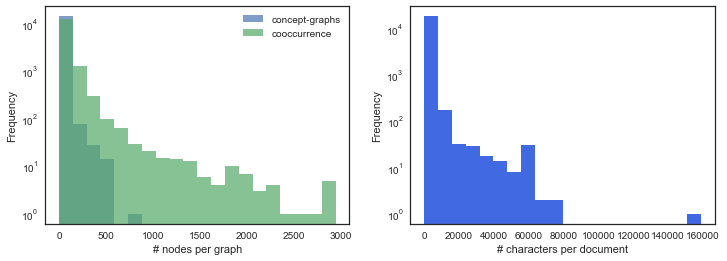

reuters-21578


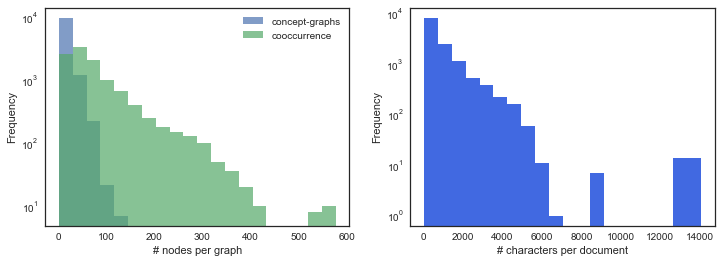

webkb


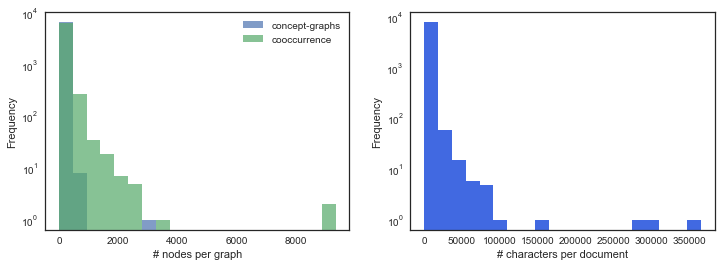

In [150]:
import dataset_helper
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

sns.set('notebook', 'white')
limit_dataset = ['ng20', 'ling-spam', 'reuters-21578', 'webkb']
#limit_dataset = ['ling-spam']
all_stats = {}
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in limit_dataset: continue
    print(dataset_name)
    X, Y = dataset_helper.get_dataset(dataset_name)
    graphs = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    number_of_nodes = []
    
    coo_graph = [x for x in graphs if 'cooccurrence' in x][0]
    gml_graph = [x for x in graphs if 'gml' in x][0]
    
    def get_num_nodes(graph_file):
        X_graph, _ = dataset_helper.get_dataset_cached(graph_file)
        return [nx.number_of_nodes(x) for x in X_graph]
    
    stats = {
        'cooccurrence': get_num_nodes(coo_graph),
        'concept-graphs': get_num_nodes(gml_graph)
    }
    min_len = min([len(v) for k, v in stats.items()])
    graph_stats = {k: v[:min(min_len, len(v))] for k, v in stats.items()}
    df = pd.DataFrame(graph_stats)
    figsize = (12, 4)
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = figsize)
    colors = reversed(["orangered", "royalblue"])
    colors = None
    df.plot(kind = 'hist', alpha = 0.7, bins=20, logy = True, color=colors, ax=ax[0])
    ax[0].set_xlabel('# nodes per graph')
    
    text_stats = {'doc_lengths': [len(x) for x in X]}
    df = pd.DataFrame(text_stats)
    df.plot(kind = 'hist', bins=20, legend = False, logy = True, ax=ax[1], color = 'royalblue')
    ax[1].set_xlabel('# characters per document')
    plt.show()
    fig.savefig('tmp/other/stats-{}.png'.format(dataset_name), dpi = 150)
    all_stats[dataset_name] = {
        'graphs': graph_stats,
        'text': text_stats['doc_lengths'],
        'num_docs': len(X),
        'num_classes': len(set(Y))
    }


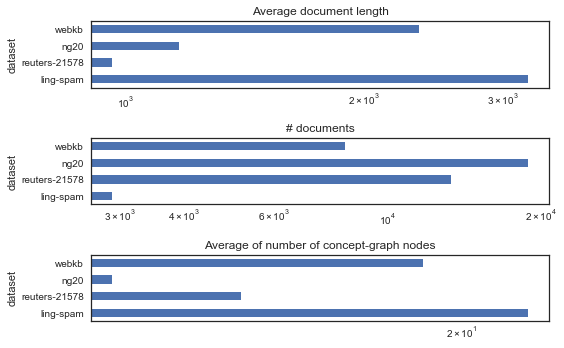

In [194]:
import numpy
out = []
for dataset, stats in all_stats.items():
    out.append((dataset, np.mean(stats['text']), np.mean(stats['graphs']['cooccurrence']), np.mean(stats['graphs']['concept-graphs']), stats['num_docs'], stats['num_classes']))
    
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8, 5))

df = pd.DataFrame(out, columns = ['dataset', 'avg_doc_length', 'avg_coo_node_num', 'avg_cp_node_num', 'num_docs', 'num_classes'])
df = df.set_index('dataset')
#, ('# classes', 'num_classes')
for idx, (name, x) in enumerate([('Average document length', 'avg_doc_length'), ('# documents', 'num_docs'), ('Average of number of concept-graph nodes', 'avg_cp_node_num')]):
    ax = axes[idx]
    df[x].plot(kind = 'barh', logx = True, title = name, ax = ax)
fig.tight_layout()
fig.savefig('tmp/other/stats-datasets.png', dpi = 120)
plt.show()